# Text Analytics Group Assignment  
### Members -  
1. __12120011__ - Harsimar Singh Arora
2. __12120027__ - Rohini Purnima
3. __12120032__ - Tipu Thakur
4. __12120035__ - Mohit Kothari
5. __12120081__ - Priya Ranjan Kar



In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import ngrams
from nltk import corpus
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric

C:\Users\harsi\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#reading the data from file.
inputData = pd.read_csv("C:\\Users\\harsi\\OneDrive - Indian School of Business\\AMPBA\\Term2\\IntroductionToTextAnalytics\\Assignment\\uber_reviews_itune.csv",
                       encoding='cp1252')
inputData.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02


In [3]:
#Datatypes in the file
inputData.dtypes

Author_Name    object
Title          object
Author_URL     object
App_Version    object
Rating          int64
Review         object
Date           object
dtype: object

#### 1. Pre-Processing

From the dataset, we have observed that there are two columns based on which we decide the sentiment of the people towards their uber rides -  
__Title and Review__     
We will be merging these columns and decide on the sentiment scores.  
In some reviews, in __Author_Name__, people have mentioned their moods as well, but many have also mentioned about their actual names. Hence, we will not take this column in Sentiment Analysis.

In [4]:
#Merging the Title and Review as Sentiment Data
inputData['SentimentData'] = inputData.Title + "\n" + inputData.Review
inputData.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date,SentimentData
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",29-12-2020 01:14,"Dishonest and Disgusting\nFor half an hour, we..."
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,01-01-2021 23:17,Free offer\nIf I’m not eligible for the offer ...
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,15-01-2021 23:38,Inaccurate\nConsistently inaccurate Uber Eats ...
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,08-12-2020 01:01,bad\ni had my rides canceled back to back. the...
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,15-12-2020 04:02,Double charged me for an order\nTwo of the sam...


The data present in SentimentData column is the one which needs to be analysed. Let's remove the junk from the data to be analysed.

In [5]:
#Checking emoji data from the Sentiment Data since it will act as junk.
for i in inputData.Review:
    if '<' in i and '>' in i:
        print(i)

If I’m not eligible for the offer Stop flooding my email with this false information <U+0001F621><U+0001F621><U+0001F621>
i like uber i really do but lyft has better prices <U+0001F615>
Yesterday I contacted Uber service and I paid my ride automatically and until now the ride didn’t pick up me, this application is a sheet, hard to understand, and no service.<U+0001F621><U+0001F621><U+0001F621><U+0001F621><U+0001F621>
ok so i ise uber to get to work 7/10 times a week. ive been experiencing a bug where i cant see how close or far my driver is. example: i got a driver and it says he'll be there in 13 minutes. ok cool so i wait and check 6 minutes later and it still says he'lll be there in 13 minutes. im like what the fuck its late im tryna go home after work yk so i send him this text and im like dude what the f?? are you coming or not? do i need to cancel? and then i check again and bam hes 1 minute away. i felt super bad and to make it worse he was an absolute sweetheart <U+0001F494>
ho

__Emoji data-__  
There are emojis present in the sentences(like - __<U+062A>__).  
We can perform sentiment analysis on the emojis as well. But, since the emojis are not present in each and every sentence, so we will be ingnoring as well. We will be replacing the emoji's data with empty string.

In [6]:
#Removing Emoji Data
RemoveEmoji = lambda x: re.sub("<[a-zA-Z0-9+]*>","",x).strip()
inputData.SentimentData = inputData.SentimentData.apply(RemoveEmoji)

Now, Let's remove the punctuations from the text to be analyzed.

In [7]:
#Removing Punctuations
RemovePunctuations = lambda x: re.sub("[']","",re.sub('[“!"#$%&()*+,-.:;<=>?@[\]^_`{|}”~]+',"",x)).strip()
inputData.SentimentData = inputData.SentimentData.apply(RemovePunctuations)

Let's convert the whole string to lower.

In [8]:
#Conerting Data to lower
ConvertLower = lambda x: x.lower()
inputData.SentimentData = inputData.SentimentData.apply(ConvertLower)

#### 2. Basic text and sentiment analysis

_2.1 Let's find the valence distribution and plot it -_  
  
We will try to find the sentiment score using the Vader Sentiment. This score will be between -1 to 1 and post this we will be plotting the valence distribution.

In [9]:
analyzer = SentimentIntensityAnalyzer() #Declaring Sentiment Analzer object.
stopWords = corpus.stopwords.words('english') #Fetching the stopwords.

#Function to fetch the lemmatized data.
def LemmatizeText(inputText):
    LemmatizeObject = WordNetLemmatizer()
    normalized = [" ".join([LemmatizeObject.lemmatize(word) for word in ' '.join(inputText).split()])]
    return normalized

#Function to Fetch the Sentiment scores for the Document/Sentence
def DocumentAnalyzer(document):
    sentenceList = sent_tokenize(document)
    documentPolarity = []
    sentenceIndex = []
    for i in range(len(sentenceList)):
        sentencePolarity = analyzer.polarity_scores(sentenceList[i])
        documentPolarity.append(sentencePolarity)
        sentenceIndex.append(i)
    documentDataframe = pd.DataFrame(documentPolarity)
    documentDataframe.insert(0, 'SentenceIndex', sentenceIndex)
    documentDataframe.insert(documentDataframe.shape[1], 'Sentence', sentenceList)
    documentDataframe.rename(columns={'neg':'NegativeScore','pos':'PositiveScore','neu':'NeutralScore','compound':'Compound'}, inplace=True)
    return(documentDataframe)

In [10]:
#Function to fetch the Sentiment Scores for the whole corpus
def DocumentFromCorpusAnalyzer(corpus):
    SentimentData = pd.DataFrame(corpus.SentimentData)
    analyzedDataframe = pd.DataFrame(columns=['DocumentIndex', 'SentenceIndex', 'NegativeScore', 'NeutralScore', 'PositiveScore', 'Compound', 'Sentence'])    
    for i1 in range(len(SentimentData)):
        document = str(SentimentData.iloc[i1].SentimentData)
        analyzedDocument = DocumentAnalyzer(document)
        analyzedDocument.insert(0, 'DocumentIndex', i1)
        analyzedDataframe = pd.concat([analyzedDataframe, analyzedDocument], axis=0)
    return(analyzedDataframe)

In [11]:
AnalyzedData = DocumentFromCorpusAnalyzer(inputData)
AnalyzedData.reset_index(inplace = True, drop = True)
AnalyzedData.head()

,DocumentIndex,SentenceIndex,NegativeScore,NeutralScore,PositiveScore,Compound,Sentence
0,0,0,0.099,0.868,0.034,-0.4588,dishonest and disgusting\nfor half an hour we ...
1,1,0,0.107,0.732,0.161,0.2732,free offer\nif i’m not eligible for the offer ...
2,2,0,0.167,0.833,0.000,-0.3400,inaccurate\nconsistently inaccurate uber eats ...
3,3,0,0.124,0.800,0.075,-0.5006,bad\ni had my rides canceled back to back they...
4,4,0,0.088,0.855,0.056,-0.3484,double charged me for an order\ntwo of the sam...


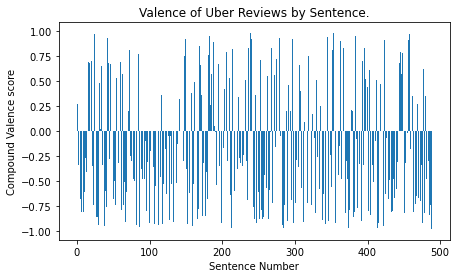

In [12]:
#Valence distribution across Corpus and Documents
x = pd.Series([x for x in range(len(AnalyzedData))])
y = AnalyzedData.Compound
plt.figure(figsize=[7,4])
plt.bar(x, y)
plt.xlabel("Sentence Number")
plt.ylabel("Compound Valence score")
plt.title("Valence of Uber Reviews by Sentence.")
plt.show()

_2.2 Let's plot the historgram for the sentiment score -__  
  
With the help of histogram, we will observe the sentiment type of people using Uber.

(array([35., 29., 36., 30., 27., 27., 27., 17., 38., 12., 16., 11., 46.,
         8.,  3., 11.,  7., 13., 11., 11., 12., 12., 18., 14., 18.]),
 array([-0.9872  , -0.908156, -0.829112, -0.750068, -0.671024, -0.59198 ,
        -0.512936, -0.433892, -0.354848, -0.275804, -0.19676 , -0.117716,
        -0.038672,  0.040372,  0.119416,  0.19846 ,  0.277504,  0.356548,
         0.435592,  0.514636,  0.59368 ,  0.672724,  0.751768,  0.830812,
         0.909856,  0.9889  ]),
 <BarContainer object of 25 artists>)

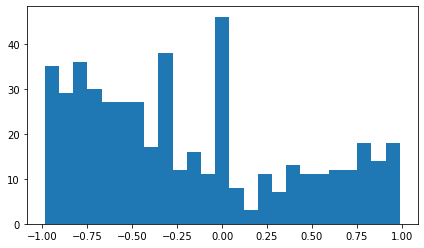

In [13]:
#Plotting the Histogram for the sentiment scores
plt.figure(figsize=[7,4])
plt.hist(AnalyzedData.Compound, bins=25)

Maximum sentiments are focussed towards the negative side. We can also observe the peak on neutral side as well, but the postive sentiments are quiet less.

_2.3 Let's plot bigrams for finding the mainly used words -_  
  
Word tokenizer will help to list the words and based on that we will be plotting the bigrams.

In [14]:
#Tokenizing the words - 
WordList = []
for sentence in AnalyzedData.Sentence:
    for word in word_tokenize(sentence):
        if re.search('[a-zA-Z0-9]',word):
            WordList.append(word)

In [15]:
#Stop Words removal -
stopWords = corpus.stopwords.words('english')
WordList = [i for i in WordList if i not in stopWords]

In [16]:
#Checking the bigrams for analyzing the most posted words
Bigrams = pd.Series(ngrams(WordList,2)).value_counts()
BigramsMaxUsed = Bigrams[Bigrams > 10]
BigramsMaxUsed

(customer, service)    79
(use, uber)            32
(uber, pass)           27
(uber, eats)           26
(customer, support)    22
(uber, app)            19
(payment, method)      19
(get, ride)            18
(use, lyft)            18
(using, uber)          17
(every, time)          17
(uber, driver)         17
(minutes, away)        16
(money, back)          16
(credit, card)         16
(used, uber)           13
(get, work)            13
(use, app)             13
(request, ride)        12
(trying, get)          12
(uber, cash)           12
(cancellation, fee)    12
(scheduled, ride)      11
(uber, drivers)        11
(family, profile)      11
dtype: int64

<AxesSubplot:>

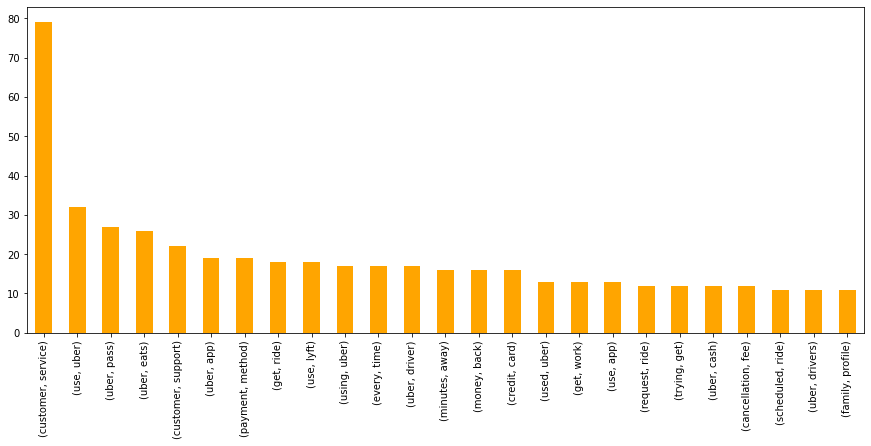

In [17]:
#Visualizing the Bigram data
BigramsMaxUsed.plot.bar(color='orange', figsize = [15,6])

The maximum used word is - ___Customer Service___, people are more towards the service provided to them.

_2.4 Let's also checkout the trigrams for finding the mainly used words -_  

In [18]:
#Checking the trigrams for analyzing the most posted words
Trigrams = pd.Series(ngrams(WordList,3)).value_counts()
TrigramsMaxUsed = Trigrams[Trigrams > 3]
TrigramsMaxUsed

(worst, customer, service)       7
(horrible, customer, service)    7
(get, money, back)               5
(uber, credit, card)             5
(terrible, customer, service)    5
(charged, uber, pass)            5
(want, money, back)              5
(uber, pass, never)              4
(20, minutes, away)              4
(poor, customer, service)        4
(customer, service, app)         4
(customer, support, uber)        4
(use, lyft, instead)             4
dtype: int64

<AxesSubplot:>

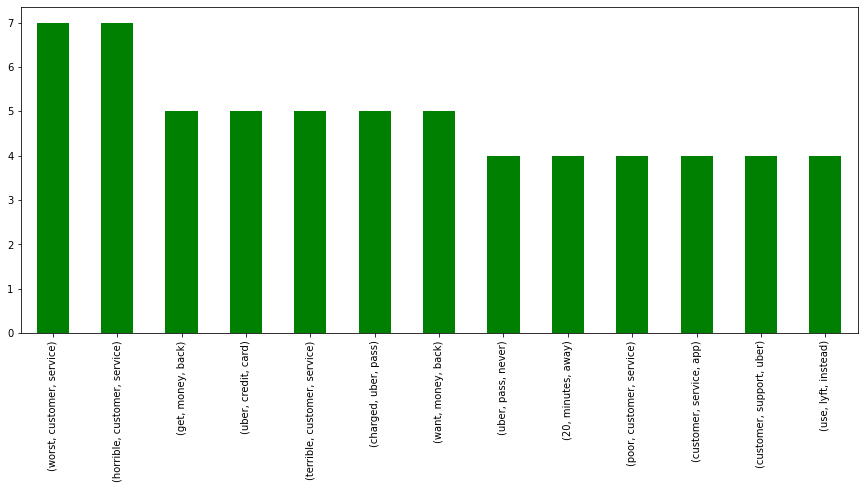

In [19]:
#Visualizing the Trigram data
TrigramsMaxUsed.plot.bar(color='green', figsize = [15,6])

With bigrams, we got to know that people focus towards customer service, and from trigrams we can observe that people are facing bad experience with the customer service. Worst and Horrible customer service being on top, company needs to focus on its services to customers.

_2.5 Let's plot the word cloud for the corpus to check the most used words -_  
  
We will be using only the non-stopwords and also we will be removing words like driver, uber, rides and app. These words will not add much significance to the cloud and rather will make us ignore important words. 

In [20]:
#Tokening the words
cloudData = ''
for word in WordList:
    lowerWord = word.lower().strip()
    cloudData += word + " "
cloudData = cloudData.replace('uber','').replace('apps','').replace('drivers','').replace('rides','').replace(
    'app','').replace('driver','').replace('ride','')
cloudData

'dishonest disgusting half hour tried every  service take short trip  falsely advertised dropoffs certain times deliver finally downloded lyft immediately got car two minutes away free offer eligible offer stop flooding email false information inaccurate consistently inaccurate  eats eta food menus often errors bad  canceled back back still charged account cancellation fee tried get money back gave money  want money back card also able get touch help  terrible double charged order two orders added accident restaurant tried remove order couldnt tried reaching  eats restaurant ended charging order told put claim  months later  charges customer service short look issue depth using  years last straw supporting bam instead another customer lost best even offer promotions one really wants pick cheap price end paying  6 minutes away hate  hate  canceled  even give money back yall scammers good times find  gps always miss turns pick ups drops offs annoying customer support number deleting  cus

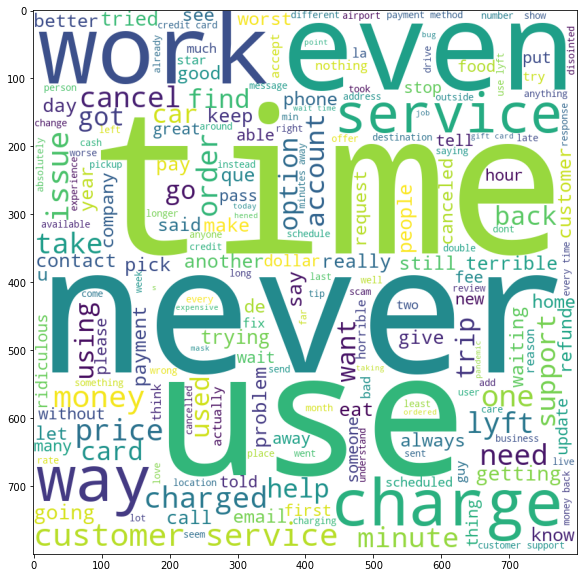

In [21]:
#Plotting the word cloud
wCloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(cloudData)
plt.figure(figsize=[10,10])
plt.imshow(wCloud)

#### 3. Feature construction and extraction

_3.1 Sentiment Scores -_  
  
We are aware that sentiment is going towards the negative direction, considering the whole corpus. Let's try to check how the sentiment are based on the ratings.

In [22]:
#Adding the Ratings to the analyzed dataset
AnalyzedData['Ratings'] = inputData.Rating
AnalyzedData.head()

,DocumentIndex,SentenceIndex,NegativeScore,NeutralScore,PositiveScore,Compound,Sentence,Ratings
0,0,0,0.099,0.868,0.034,-0.4588,dishonest and disgusting\nfor half an hour we ...,1
1,1,0,0.107,0.732,0.161,0.2732,free offer\nif i’m not eligible for the offer ...,2
2,2,0,0.167,0.833,0.000,-0.3400,inaccurate\nconsistently inaccurate uber eats ...,2
3,3,0,0.124,0.800,0.075,-0.5006,bad\ni had my rides canceled back to back they...,1
4,4,0,0.088,0.855,0.056,-0.3484,double charged me for an order\ntwo of the sam...,1


In [23]:
#Grouping by the Ratings based on median
AnalyzedData.groupby('Ratings').agg({"Compound":"mean"})

,Compound
Ratings,
1,-0.206680
2,-0.277007
3,0.048351
4,-0.478246
5,0.013858


There is an unusual observation here with the rating 4. We have maximum negative sentiments in this rating, which might be due to junk data, non-removal of stopwords or data count within this head being minimum or maximum.

_3.2 DTM Formation -_  
  
We will be performing the DTM building activity, which is the representation of text data as matrix.

In [24]:
#Create the instance of SnowballStemmer, helpful in stemming purposes.
StemmerObject = SnowballStemmer("english")

#Let's define a function to create which will give us the stemmed words - 
def FetchStemmedAndOriginalTokens(text):
    appropriateTokens = []
    stemmedTokens = []
    tokenizedWords = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    for word in tokenizedWords:
        if re.search('[a-zA-Z]',word):
            appropriateTokens.append(word)
    stemmedTokens = [StemmerObject.stem(token) for token in appropriateTokens]
    return (stemmedTokens, appropriateTokens)

In [25]:
#Let's fetch the stemmed words and compare with their tokens.
totalAppropriateTokens = []
totalStemmedTokens = []
for document in AnalyzedData.Sentence:
    (stems,tokens) = FetchStemmedAndOriginalTokens(document)
    totalAppropriateTokens.extend(tokens)
    totalStemmedTokens.extend(tokens)
pd.DataFrame({'StemmedData':totalStemmedTokens,'ActualData':totalAppropriateTokens})

,StemmedData,ActualData
0,dishonest,dishonest
1,and,and
2,disgusting,disgusting
3,for,for
4,half,half
...,...,...
32381,i,i
32382,m,m
32383,done,done
32384,using,using


In [26]:
#Fetches the Stemmed tokens
def FetchStemmedTokens(text):
    appropriateTokens = []
    stemmedTokens = []
    tokenizedWords = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    for word in tokenizedWords:
        if re.search('[a-zA-Z]',word):
            appropriateTokens.append(word)
    stemmedTokens = [StemmerObject.stem(token) for token in appropriateTokens]
    return stemmedTokens

#Let's build a Document Term Matrix(DTM) using TFIDF object- 
tfidfVectorizerObject = TfidfVectorizer(max_df=1, # max proportion of docs word is present in
                        max_features=200000,
                        min_df=0,
                        stop_words='english',
                        use_idf=True, 
                        tokenizer=FetchStemmedTokens, 
                        ngram_range=(1,3))

In [27]:
#Let's fit the transform.
outputDTM = tfidfVectorizerObject.fit_transform(AnalyzedData.Sentence)
outputDTM.shape

C:\Users\harsi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(489, 25403)

In [28]:
outputDTM.todense()[:20,:20]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [29]:
#Let's check the feature names for the corpus.
tfidfVectorizerObject.get_feature_names()[:50]

['1/4th',
 '1/4th trip',
 '1/4th trip steal',
 '10k/year',
 '10k/year uber',
 '10k/year uber liter',
 '10min',
 '10min driver',
 '10min driver just',
 '10—said',
 '10—said estim',
 '10—said estim m',
 '15min',
 '15min 20min',
 '15min 20min skip',
 '19h',
 '19h fica',
 '19h fica mai',
 '200m',
 '200m secur',
 '200m secur win',
 '20min',
 '20min skip',
 '20min skip greedi',
 '20x',
 '20x driver',
 '20x driver alway',
 '22s',
 '22s promot',
 '22s promot remind',
 '24hrs',
 '24hrs respons',
 '24hrs respons let',
 '2day',
 '2day later',
 '2day later messag',
 '2x',
 '2x price',
 '2x price kept',
 '31st',
 '31st abl',
 '31st abl ride',
 '35min',
 '35min away',
 '35min away sent',
 '39x',
 '39x higher',
 '39x higher charg',
 '3f',
 '3f driver']

With this, we get to see the Document Term Matrix(DTM), Stemmed words with their tokens and the featured names.

_3.3 Latent Topic Model -_  
  
We will be using the gensim library for Latent Topic Modelling.

In [30]:
#Lemmatize the sentences and Tokenize the words for the lemmatized sentences
LemmatizeObject = WordNetLemmatizer()
def FetchLemmatizedData(AllSentences):
    requiredSentences = [strip_punctuation(Sentence) for Sentence in AllSentences]
    requiredSentences = [strip_tags(Sentence) for Sentence in requiredSentences]
    requiredSentences = [strip_numeric(Sentence) for Sentence in requiredSentences]
    requiredSentences = [[" ".join([i for i in Sentence.lower().split() if i not in stopWords])] for Sentence in requiredSentences]
    normalizedSentences = [[" ".join([LemmatizeObject.lemmatize(word) for word in ' '.join(Sentence).split()])] for Sentence in requiredSentences]
    return normalizedSentences
LemmatizedData = FetchLemmatizedData(AnalyzedData.Sentence)
GensimTokenizedWords = [[word for word in ' '.join(sentenceWords).split()] for sentenceWords in LemmatizedData]
GensimTokenizedWords

[['dishonest',
  'disgusting',
  'half',
  'hour',
  'tried',
  'every',
  'uber',
  'service',
  'take',
  'short',
  'trip',
  'uber',
  'falsely',
  'advertised',
  'dropoffs',
  'certain',
  'time',
  'deliver',
  'finally',
  'downloded',
  'lyft',
  'immediately',
  'got',
  'car',
  'two',
  'minute',
  'away'],
 ['free',
  'offer',
  'i’m',
  'eligible',
  'offer',
  'stop',
  'flooding',
  'email',
  'false',
  'information'],
 ['inaccurate',
  'consistently',
  'inaccurate',
  'uber',
  'eats',
  'eta',
  'food',
  'menu',
  'often',
  'error'],
 ['bad',
  'ride',
  'canceled',
  'back',
  'back',
  'still',
  'charged',
  'account',
  'cancellation',
  'fee',
  'tried',
  'get',
  'money',
  'back',
  'gave',
  'money',
  'app',
  'want',
  'money',
  'back',
  'card',
  'also',
  'wasn’t',
  'able',
  'get',
  'touch',
  'help',
  'uber',
  'terrible'],
 ['double',
  'charged',
  'order',
  'two',
  'order',
  'added',
  'accident',
  'restaurant',
  'tried',
  'remove',
  

In [31]:
#Let's fetch the DTM via Gensim.
id2word = Dictionary(GensimTokenizedWords)
gensimDTM = [id2word.doc2bow(WordsOfSentence) for WordsOfSentence in GensimTokenizedWords]
print(gensimDTM[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2)]]


In [32]:
#Formation of the LDA Model and and considering 5 groups.
lda_model = LdaModel(corpus=gensimDTM,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

LDA model helps us to find the topics. Now with the LDA model we will try to find the beta and gamma matrices. These matrices are defined as -  
  
__Beta__ - Mapping tokens to topics.  
__Gamma__ - Mapping documents to topics.

In [33]:
#Beta matrix fetching function
def FetchBetaFactor():
    betaTopics = lda_model.get_topics()
    requiredDataframe = pd.DataFrame(data=betaTopics)
    requiredDataframe.columns = list(id2word.token2id)
    names = ['TOPIC_' + str(x+1) for x in range(len(requiredDataframe))]
    requiredDataframe.rename(index=pd.Series(names), inplace=True)
    return requiredDataframe
betaDf = FetchBetaFactor()
betaDf

,advertised,away,car,certain,deliver,disgusting,dishonest,downloded,dropoffs,every,...,swerving,tend,witnessed,worksite,redemption,reporting,feed,hade,happening,police
TOPIC_1,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117,0.000118,0.000117,0.000117,0.000117,...,0.000118,0.000118,0.000118,0.000118,0.000117,0.000117,0.000117,0.000117,0.000117,0.000117
TOPIC_2,0.000114,0.000034,0.000170,0.000411,0.000197,0.000309,0.000420,0.000114,0.000114,0.001962,...,0.000034,0.000034,0.000034,0.000034,0.000339,0.000339,0.000035,0.000035,0.000035,0.000035
TOPIC_3,0.000045,0.003942,0.002908,0.000048,0.000045,0.000045,0.000046,0.000045,0.000045,0.000093,...,0.000045,0.000045,0.000045,0.000045,0.000047,0.000047,0.000455,0.000455,0.000455,0.000455
TOPIC_4,0.000054,0.006247,0.004607,0.000052,0.000052,0.000051,0.000065,0.000054,0.000054,0.003163,...,0.000516,0.000516,0.000516,0.000516,0.000053,0.000053,0.000056,0.000056,0.000056,0.000056
TOPIC_5,0.000053,0.000963,0.007549,0.000058,0.000053,0.000053,0.000055,0.000053,0.000053,0.003966,...,0.000053,0.000053,0.000053,0.000053,0.000056,0.000056,0.000054,0.000054,0.000054,0.000054


In [34]:
#Beta matrix fetching function
def FetchGammaFactor():
    #for sentence in list(AnalyzedData.Sentence):
    GammaColumns = []
    data = [0]*5
    dtmOfSentences = id2word.doc2bow(list(AnalyzedData.Sentence))
    GammaSentenceTopics = lda_model.get_document_topics(dtmOfSentences)
    x1 = [x for (x,y) in GammaSentenceTopics]
    y1 = [y for (x,y) in GammaSentenceTopics]
    for i in range(len(GammaSentenceTopics)):
        x = x1[i]
        y = y1[i]
        data[x] = y
    GammaColumns.append(data)
    requiredDataframe = pd.DataFrame(data=GammaColumns)
    names = ['TOPIC_' + str(x+1) for x in range(5)]
    requiredDataframe.rename(columns=pd.Series(names),inplace=True)
    return requiredDataframe
gammaDf = FetchGammaFactor()
gammaDf

,TOPIC_1,TOPIC_2,TOPIC_3,TOPIC_4,TOPIC_5
0,0.043165,0.318328,0.235461,0.188262,0.214784


Let's find out the metrics for topic models - 
  
1.Perplexity

In [35]:
#Perplexity - 
print(f'Model Perplexity - {lda_model.log_perplexity(gensimDTM):.4f}')

Model Perplexity - -7.1118


2.Coherence Score

In [36]:
#Coherence Score - 
coherence_model_lda = CoherenceModel(model=lda_model, texts=GensimTokenizedWords, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4319350499138069


Let's compute optimal model using Coherence score - 

In [37]:
#Calculate coherence score - 
def FetchCoherenceScores(start, stop, step, DTM_Data, dictionary, texts):
    finalValues = []
    modelList = []
    topicNumbers = [i for i in range(start, stop, step)]
    for topicNumber in topicNumbers:
        lda_model = LdaModel(corpus=DTM_Data,
                             id2word=id2word,
                             num_topics=topicNumber, 
                             random_state=100,
                             update_every=1,
                             chunksize=100,
                             passes=10,
                             alpha='auto',
                             per_word_topics=True)
        modelList.append(lda_model)
        finalValues.append(CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence())
    return (modelList,finalValues)

In [38]:
#Let's find the Coherent Scores for models with topics ranging from 2 to 19.
(ModelList,CoherenceScores) = FetchCoherenceScores(2,19,1,gensimDTM,id2word,GensimTokenizedWords)
CoherenceScores

[0.6041264252086159,
 0.5873453469220739,
 0.5097836693451946,
 0.4319350499138069,
 0.4347459996774797,
 0.4094938187957239,
 0.451446019360335,
 0.43858125560928907,
 0.38076569151202,
 0.3955098968944783,
 0.38269817314856014,
 0.37168589461326323,
 0.47045854220974564,
 0.4354063034081353,
 0.41766932612372065,
 0.3851480746665774,
 0.44110401842333224]

In [39]:
#Let's find the optimal number of topics - 
CoherenceScoreList = list(enumerate(CoherenceScores))
index_max = [x for (x,y) in CoherenceScoreList if y==max(CoherenceScores)]
OptimalTopics = int(str(index_max[0]))+2
print(OptimalTopics)

2


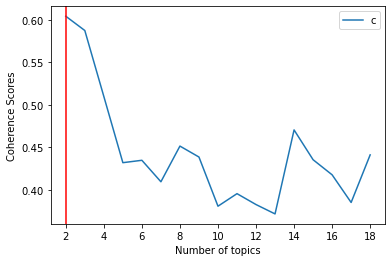

In [40]:
#Plot Coherence scores with number of topics - 
x = range(2, 19, 1)
plt.plot(x, CoherenceScores)
plt.xlabel("Number of topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=OptimalTopics, color='r')
plt.show()

Let's optimal model using Perplexity - 

In [41]:
#Calculate Perplexity Scores - 
def FetchPerplexityScores(ListOfModels):
    finalValues = []
    for model in ListOfModels:
        finalValues.append(model.log_perplexity(gensimDTM))
    return finalValues

In [42]:
#Let's find the Coherent Scores for models with topics ranging from 2 to 19.
PerplexityScores = FetchPerplexityScores(ModelList)
PerplexityScores

[-6.940936689763329,
 -6.960383534016216,
 -7.040940305957442,
 -7.111841329637149,
 -7.144828736807185,
 -7.181860429900546,
 -7.179378463803664,
 -7.187744297891219,
 -7.218583433253379,
 -7.221700762550837,
 -7.240204446076485,
 -7.238783600442997,
 -7.210411973989964,
 -7.206730322799893,
 -7.23399278734988,
 -7.27195292879238,
 -7.273254012137768]

In [43]:
#Let's find the optimal number of topics - 
PerplexityScoreList = list(enumerate(PerplexityScores))
index_min = [x for (x,y) in PerplexityScoreList if y==min(PerplexityScores)]
OptimalTopics = int(str(index_min[0]))+2
print(OptimalTopics)

18


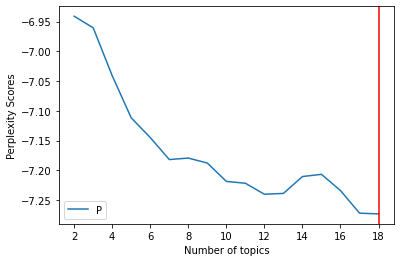

In [44]:
#Plot Perplexity scores with number of topics - 
x = range(2, 19, 1)
plt.plot(x, PerplexityScores)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity Scores")
plt.legend(("Perplexity_values"), loc='best')
plt.axvline(x=OptimalTopics, color='r')
plt.show()

In [45]:
#Let's check how the optimal model looks
optimal_model = ModelList[OptimalTopics-2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=5)

[(0,
  '0.018*"allowed" + 0.017*"they’re" + 0.014*"route" + 0.014*"company" + 0.013*"driver"'),
 (1,
  '0.036*"multiple" + 0.029*"destination" + 0.019*"could" + 0.015*"rating" + 0.013*"someone"'),
 (2,
  '0.035*"love" + 0.022*"whenever" + 0.022*"nice" + 0.019*"wont" + 0.019*"home"'),
 (3,
  '0.031*"user" + 0.029*"either" + 0.026*"mask" + 0.025*"pandemic" + 0.024*"receive"'),
 (4,
  '0.043*"dollar" + 0.035*"rate" + 0.033*"schedule" + 0.020*"delivery" + 0.019*"ride"'),
 (5,
  '0.039*"i’m" + 0.037*"card" + 0.036*"payment" + 0.025*"app" + 0.024*"work"'),
 (6,
  '0.038*"support" + 0.031*"phone" + 0.028*"credit" + 0.027*"email" + 0.026*"said"'),
 (7,
  '0.053*"driver" + 0.031*"airport" + 0.019*"u" + 0.018*"next" + 0.017*"forever"'),
 (8,
  '0.076*"ride" + 0.056*"driver" + 0.034*"time" + 0.031*"minute" + 0.020*"lyft"'),
 (9, '0.046*"que" + 0.039*"de" + 0.026*"el" + 0.018*"en" + 0.018*"se"'),
 (10,
  '0.043*"la" + 0.040*"think" + 0.036*"care" + 0.030*"price" + 0.028*"reliable"'),
 (11,
  '0.08

_3.4 Analyzing the datetime_  
  
Considering the Date column of the dataset to be date and time when the ride ends. Let's try analyzing the data first based on hour.

In [46]:
#Converting the Date column to required Datetime datatype.
AnalyzedData['EventDateTime'] = pd.to_datetime(inputData.Date, format='%d-%m-%Y %H:%M')
AnalyzedData.head()

,DocumentIndex,SentenceIndex,NegativeScore,NeutralScore,PositiveScore,Compound,Sentence,Ratings,EventDateTime
0,0,0,0.099,0.868,0.034,-0.4588,dishonest and disgusting\nfor half an hour we ...,1,2020-12-29 01:14:00
1,1,0,0.107,0.732,0.161,0.2732,free offer\nif i’m not eligible for the offer ...,2,2021-01-01 23:17:00
2,2,0,0.167,0.833,0.000,-0.3400,inaccurate\nconsistently inaccurate uber eats ...,2,2021-01-15 23:38:00
3,3,0,0.124,0.800,0.075,-0.5006,bad\ni had my rides canceled back to back they...,1,2020-12-08 01:01:00
4,4,0,0.088,0.855,0.056,-0.3484,double charged me for an order\ntwo of the sam...,1,2020-12-15 04:02:00


In [47]:
#Grouping the Sentiment Scores based on Hour. 
AnalyzedData.groupby(by=AnalyzedData.EventDateTime.dt.hour).agg({"Compound":"median"}).sort_values(by='EventDateTime')

,Compound
EventDateTime,
0,-0.30695
1,-0.31820
2,-0.46100
3,-0.42245
4,-0.25815
5,-0.25060
6,-0.21635
7,0.00000
8,-0.10270


1.Rides taken during the post-office hours have negative sentiments, which depicts that office frustration might be causing that - even little issues with services might be making the customers irritated.  
2.Afternoon rides have maximum negative sentiments, these needs to be checked up by the company.  
3.Morning hours are specifically comfortable with customers, this does not need any changes.

Let's try analyzing the data first based on weekday.

In [48]:
#Fetching the weekday based on Datetime.
AnalyzedData['Weekday'] = AnalyzedData.EventDateTime.apply(lambda x: x.day_name())
AnalyzedData.head()

,DocumentIndex,SentenceIndex,NegativeScore,NeutralScore,PositiveScore,Compound,Sentence,Ratings,EventDateTime,Weekday
0,0,0,0.099,0.868,0.034,-0.4588,dishonest and disgusting\nfor half an hour we ...,1,2020-12-29 01:14:00,Tuesday
1,1,0,0.107,0.732,0.161,0.2732,free offer\nif i’m not eligible for the offer ...,2,2021-01-01 23:17:00,Friday
2,2,0,0.167,0.833,0.000,-0.3400,inaccurate\nconsistently inaccurate uber eats ...,2,2021-01-15 23:38:00,Friday
3,3,0,0.124,0.800,0.075,-0.5006,bad\ni had my rides canceled back to back they...,1,2020-12-08 01:01:00,Tuesday
4,4,0,0.088,0.855,0.056,-0.3484,double charged me for an order\ntwo of the sam...,1,2020-12-15 04:02:00,Tuesday


In [49]:
#Grouping the Sentiment Scores based on Weekday.
AnalyzedData.groupby(by=AnalyzedData.Weekday).agg({"Compound":"mean"}).sort_values(by='Compound')

,Compound
Weekday,
Saturday,-0.277531
Friday,-0.259747
Wednesday,-0.211552
Tuesday,-0.174152
Thursday,-0.173313
Monday,-0.150420
Sunday,-0.101723


As expected, the holiday - Sunday has minimal negative sentiments, while Friday - the last working day has huge negative sentiments. We can change some services for customers based on Weekend.

#### 4. Supervised Learning phase

We will try to figure out the ratings based on sentiment scores. So, our dependent variable will be ratings and independent variable will be sentiment scores.  
1. Using the sentiment scores to predict the ratings.

In [32]:
#OLS regression for Ratings on Sentiment Score
y = AnalyzedData.Ratings
X = AnalyzedData.Compound
X = sm.add_constant(X)
#Splitting the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model1 = sm.OLS(y_train,X_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Ratings   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.092
Date:                Fri, 29 Jul 2022   Prob (F-statistic):             0.0796
Time:                        21:42:11   Log-Likelihood:                -483.46
No. Observations:                 342   AIC:                             970.9
Df Residuals:                     340   BIC:                             978.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5198      0.057     26.739      0.000       1.408       1.632
Compound       0.1619      0.092      1.758      0.080      -0.019       0.343
==============================================================================
Omnibus:                      155.781   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.653
Skew:                           2.162   Prob(JB):                    3.87e-108
Kurtosis:                       7.002   Cond. No.                         1.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
#Predicting the Test data.
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.round())
print(f'Model Accuracy is - {accuracy*100:.4f}%')

Model Accuracy is - 40.8163%


Here, we have implemented the OLS regression model keeping Ratings as the dependent variables and Sentiment Score(Compound) as the independent variable.  
In this model we get the model accuracy to be 40.81%.

2. Using Sentiment Score, Positive Score, Negative Score and Neutral Score to predict ratings.

In [49]:
#OLS regression for Ratings on Sentiment Score, Negative Score, Positive Score, Neutral Score
y = AnalyzedData.Ratings
X = AnalyzedData[['Compound','NegativeScore','PositiveScore','NeutralScore']]
X = sm.add_constant(X)
#Splitting the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model1 = sm.OLS(y_train,X_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Ratings   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.632
Date:                Fri, 29 Jul 2022   Prob (F-statistic):             0.0342
Time:                        21:52:27   Log-Likelihood:                -482.74
No. Observations:                 342   AIC:                             975.5
Df Residuals:                     337   BIC:                             994.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           159.0167    134.735      1.180      0.239    -106.011     424.045
Compound         -0.0447      0.141     -0.317      0.751      -0.322       0.233
NegativeScore  -157.1709    134.735     -1.167      0.244    -422.198     107.856
PositiveScore  -155.8357    134.791     -1.156      0.248    -420.973     109.301
NeutralScore   -157.7373    134.735     -1.171      0.243    -422.766     107.291
==============================================================================
Omnibus:                      147.633   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.477
Skew:                           2.067   Prob(JB):                     2.25e-96
Kurtosis:                       6.718   Cond. No.                     6.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
#Predicting the Test data.
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.round())
print(f'Model Accuracy is - {accuracy*100:.4f}%')

Model Accuracy is - 46.9388%


Here, we have implemented the OLS regression model keeping Ratings as the dependent variables and Sentiment Score(Compound), Sentiment Score, Positive Score, Negative Score and Neutral Score as the independent variables.  
In this model we get the model accuracy to be 46.94%.

#### 5. Conclusion and Recommendations

Based on the analysis done we understand and recommend the following-  

1. The Valence distribution and histogram show a more negatively skewed graph of customer reviews, with a peak in neautral reviews as well. Uber should understand the cause and commonality of the concerns and apply the necessary changes to push the graph towards the positive end.

2. We understand from the Bi-grams that most of the reviews are about the customer service provided by Uber. Uber needs to analyse the positive and negative reviews about the customer service. They need to continue implementing & promote the positives and work on solving and reducing the negatives.

3. Further, we understand from the tri-grams that the words associated with most of the customer service reviews are 'worst' & 'horrible'. Uber is to focus on its customer services practises at the highest priority and provide extensive training to the staff on how to provide the right help to customers in distress.

4. Compound scores of sentiment analysis done on reviews and it's comparision with the time booking tells us that most of the negative reviews come through between 10hrs - 14hrs, additionally, there are also negative reviews coming through post 19hrs. This peak could be due to a lot of people using the app to travel to and from work or travelling for other chores, as these are peak work timings. This probably tells that the app and customer service is unable to function well during rush hours. Uber needs to understand the issue iwth functionality during peak hours and also train its personnel on how to deal with continuous and high urgency calls during rush hours.

#### 6. Interactive application

We have created an interative application for __Basic text and sentiment analysis__. The following steps need to be followed - 
1. Below mentioned step needs to be executed for the library installation.
2. Post the above step, the streamlit run command cell needs to be run which will make the application running on the separate browser tab.
3. The file

In [50]:
!pip install streamlit
!pip install pandas
!pip install regex
!pip install matplotlib
!pip install altair
!pip install wordcloud
!pip install sklearn
!pip install vaderSentiment
!pip install nltk

In [51]:
#import streamlit
!streamlit run https://raw.githubusercontent.com/Harsimar-19/TextAnalytics-GroupProject/main/StreamlitFiles/StreamlitApp_Group.py

^C


# Thank You!